D:\Anaconda\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


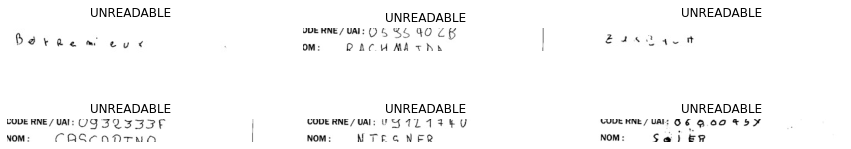

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.backend import ctc_batch_cost, get_value, ctc_decode
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

# Đọc tệp CSV
train = pd.read_csv('D:/Study/Truc_quan_hoa_data/written_name_v2/written_name_train_v2.csv')
valid = pd.read_csv('D:/Study/Truc_quan_hoa_data/written_name_v2/written_name_validation_v2.csv')


train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'D:/Study/Truc_quan_hoa_data/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

def preprocess(img):
    
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

train_size = 30000
batch_size = 1000
valid_size= 3000

train_x = []
for i in range(0, train_size, batch_size):
    batch_dir = f'D:/Study/Truc_quan_hoa_data/processed_images/batch_{i // batch_size}'
    for j in range(batch_size):
        img_dir = os.path.join(batch_dir, f"processed_img_{i}.jpg")
        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        image = image/255.
        train_x.append(image)

valid_x = []

for i in range(valid_size):
    img_dir = 'D:/Study/Truc_quan_hoa_data/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [2]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

# Các hàm chuyển đổi nhãn
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64

def label_to_num(label):
    label_num = []
    for ch in label:
        index = alphabets.find(ch)
        if index == -1:
            raise ValueError(f"Character {ch} not found in alphabets.")
        label_num.append(index)
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:
            break
        else:
            ret += alphabets[ch]
    return ret

train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

# Định nghĩa mô hình
input_data = Input(shape=(256, 64, 1), name='input')
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Dropout(0.3)(inner)  # Thêm Dropout sau LSTM
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)
inner = Dropout(0.3)(inner)  # Thêm Dropout sau LSTM
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)

# Hàm mất mát CTC
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return ctc_batch_cost(labels, y_pred, input_length, label_length)

labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

# Huấn luyện mô hình
optimizer = Adam(learning_rate=0.00001)  # Giảm learning rate
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

history = model.fit(
    x=[train_x, train_y, train_input_len, train_label_len],
    y=train_output,
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
    epochs=60,
    batch_size=128
)

MemoryError: Unable to allocate 3.66 GiB for an array with shape (30000, 256, 64) and data type float64

In [ ]:
# Dự đoán
preds = model.predict(valid_x)
decoded = get_value(ctc_decode(preds, input_length=np.ones(preds.shape[0]) * preds.shape[1], greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

# Hiển thị dự đoán
test = pd.read_csv('D:/Study/Truc_quan_hoa_data/written_name_v2/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'D:/Study/Truc_quan_hoa_data/test_v2/test'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image / 255.0
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = get_value(ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()